In [12]:
import sys, os
sys.path.append(os.path.realpath(".."))

import util_funcs
from importlib import reload
reload(util_funcs)
from copy import deepcopy as cp

import data_reader as read
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import pywt
import tsfresh.feature_extraction.feature_calculators as feats
import constants
import clinical_text_analysis as cta
reload(cta)
import tsfresh
import ensembleReader as er
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, r2_score
from os import path

reload(read)
import wf_analysis.datasets as wfdata
import wf_analysis.filters as filt
reload(filt)
from addict import Dict
import time
import pickle as pkl
import tsfresh.feature_extraction.feature_calculators as tsf
import pyedflib as edf
import keras_models.dataGen as dg 

In [2]:
import predictSeizureMultipleLabels as sml
reload(sml)

<module 'predictSeizureMultipleLabels' from '/home/ms994/dbmi_eeg_clustering/predictSeizureMultipleLabels.py'>

In [3]:
eds = sml.getDataSampleGenerator(4,4,4,4,12)

Starting 12 processes
retrieving: 0
Starting 12 processes
retrieving: 0
retrieving: 1000
retrieving: 2000
retrieving: 3000


In [4]:
train_label_files_segs = eds.get_train_split()

starting custom_annotater
Starting 20 processes
retrieving: 0
retrieving: 1000
retrieving: 2000


In [5]:
train_edss = er.EdfDatasetSegmentedSampler(segment_file_tuples=train_label_files_segs, num_samples=4, max_bckg_samps_per_file=4, n_process=8, gap=4*pd.Timedelta(seconds=1))
train_tkn_file_paths = [train_edss.sampleInfo[key].token_file_path for key in train_edss.sampleInfo.keys()]
train_patients = [read.parse_edf_token_path_structure(tkn_file_path)[1] for tkn_file_path in train_tkn_file_paths]

In [6]:
sml.get_data(er.EdfDatasetSegmentedSampler.DETECT_MODE, max_samples=10, n_process=10, max_bckg_samps_per_file=1, num_seconds=4)

TypeError: get_data is missing value(s) for ['max_bckg_samps_per_file_test']

# Try debugging the neural network from predictSeizureConvExp.py

In [2]:
from keras.models import load_model

In [136]:
model = load_model("/n/scratch2/ms994/out/GLDHPNWDDAYFBHAZ_retry.h5")

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000, 21, 1)       0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1000, 21)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1000, 32)          704       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1000, 32)          0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 1000, 32, 1)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1000, 32, 1)       4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1000, 32, 5)       85        
__________

In [5]:
input_layer = model.layers[0]

In [7]:
flatten_layer.name

'flatten_1'

In [8]:
for layer in model.layers:
    layer.trainable = False

In [9]:
from keras_models.cnn_models import conv2d_gridsearch_pre_layers
from keras.layers import Input, Reshape, Dense, TimeDistributed, Dropout
from keras import Model
from keras.optimizers import Adam

## Data setup

In [2]:
edss = er.EdfDatasetSegments(pre_cooldown=4, post_cooldown=4, sample_time=4, num_seconds=1, n_process=16)

Starting 16 processes
retrieving: 0
Starting 16 processes
retrieving: 0
retrieving: 1000
retrieving: 2000
retrieving: 3000


In [3]:
train_label_files_segs = edss.get_train_split()

starting custom_annotater
Starting 20 processes
retrieving: 0
retrieving: 1000
retrieving: 2000


In [4]:
valid_file_segs = edss.get_valid_split() #since I can't actually replicate the split, i'm gonna try to use this split instead

starting custom_annotater
Starting 20 processes
retrieving: 0


In [5]:
train_valid_file_segs = train_label_files_segs + valid_file_segs

In [6]:
len(train_valid_file_segs)

3177

In [7]:
test_label_files_segs = edss.get_test_split()

starting custom_annotater
Starting 20 processes
retrieving: 0


In [8]:
mode = er.EdfDatasetSegmentedSampler.DETECT_MODE
reload(er)
train_edss = er.EdfDatasetSegmentedSampler(segment_file_tuples=train_label_files_segs, mode=mode, max_bckg_samps_per_file=5, n_process=8, gap=pd.Timedelta(seconds=4), overlapping_augmentation=False)
train_edss.verbose = False
valid_edss = er.EdfDatasetSegmentedSampler(segment_file_tuples=edss.get_valid_split(), mode=mode, max_bckg_samps_per_file=5, n_process=8, gap=pd.Timedelta(seconds=4), overlapping_augmentation=False)
valid_edss.verbose = False

starting custom_annotater
Starting 20 processes
retrieving: 0


In [9]:
test_edss = er.EdfDatasetSegmentedSampler(segment_file_tuples=test_label_files_segs,  max_bckg_samps_per_file=5, mode=mode, n_process=8, gap=pd.Timedelta(seconds=1), overlapping_augmentation=False)
test_edss.verbose = False

In [100]:
train_edss.n_process = 1
train_edss.use_mp = False

In [101]:
train_edss.sampleInfo[114]

{'label': False,
 'token_file_path': '/home/ms994/v1.5.0/edf/train/01_tcp_ar/131/00013182/s001_2015_10_07/00013182_s001_t000.edf',
 'sample_num': 16.0,
 'sample_width': Timedelta('0 days 00:00:04')}

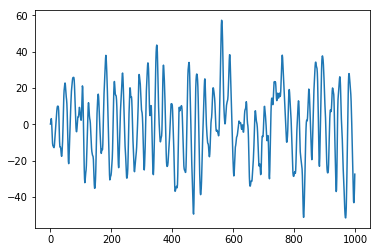

In [102]:
plt.plot(train_edss[113][0].T[0])

In [10]:
# train_edss_scaled = read.EdfStandardScaler(train_edss)
# valid_edss_scaled = read.EdfStandardScaler(valid_edss)

In [16]:
from keras_models.dataGen import EdfDataGenerator, RULEdfDataGenerator
import keras_models.dataGen as dg
reload(dg)

<module 'keras_models.dataGen' from '/home/ms994/dbmi_eeg_clustering/keras_models/dataGen.py'>

In [19]:
edg = dg.DataGenMultipleLabels(train_edss, num_labels=1, n_classes=[2], precache=False, batch_size=2, labels=[train_edss.sampleInfo[key].label for key in train_edss.sampleInfo.keys()])

In [192]:
train_edss.use_mp = False
valid_edss.use_mp = False
edg = dg.RULEdfDataGenerator(train_edss, n_classes=2, precache=False, batch_size=16, labels=[train_edss.sampleInfo[key].label for key in train_edss.sampleInfo.keys()])
valid_edg = dg.RULEdfDataGenerator(valid_edss, n_classes=2, precache=False, batch_size=16, labels=[valid_edss.sampleInfo[key].label for key in valid_edss.sampleInfo.keys()])

In [193]:
test_edss.use_mp = False
test_edg = dg.EdfDataGenerator(test_edss, n_classes=2, precache=False, batch_size=32, shuffle=False)
test_labels = [test_edss.sampleInfo[key].label for key in test_edss.sampleInfo.keys()]

In [106]:
seizureLabels = [train_edss.sampleInfo[key].label for key in train_edss.sampleInfo.keys()]

## Try and see if the weights of the last layer of flatten can be used to predict for session

### Parse the session ids of all the EEGs for a combined train_valid split
We do this because I can't actually replicate the random split of patients between train and valid

In [194]:
tkn_file_paths = [train_edss.sampleInfo[key].token_file_path for key in train_edss.sampleInfo.keys()]

In [195]:
patients = [read.parse_edf_token_path_structure(tkn_file_path)[1] for tkn_file_path in tkn_file_paths]

In [196]:
allPatients = list(set(patients + [read.parse_edf_token_path_structure(valid_edss.sampleInfo[key].token_file_path)[1] for key in valid_edss.sampleInfo.keys()]))

In [197]:
patientInd = [allPatients.index(patient) for patient in patients]

In [198]:
validPatientInd = [allPatients.index(read.parse_edf_token_path_structure(valid_edss.sampleInfo[key].token_file_path)[1]) for key in valid_edss.sampleInfo.keys()]

In [199]:
seizureLabels = [train_edss.sampleInfo[key].label for key in train_edss.sampleInfo.keys()]
validSeizureLabels = [valid_edss.sampleInfo[key].label for key in valid_edss.sampleInfo.keys()]

In [200]:
for i in range(len(seizureLabels)):
    train_edss.sampleInfo[i].label = (patientInd[i])

In [201]:
for i in range(len(validSeizureLabels)):
    valid_edss.sampleInfo[i].label = (validPatientInd[i])

In [202]:
edg = dg.EdfDataGenerator(train_edss, n_classes=len(allPatients))

In [203]:
len(allPatients)

308

### Try to make a new model to predict patients using frozen weights of old model

In [204]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000, 21, 1)       0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1000, 21)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1000, 32)          704       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1000, 32)          0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 1000, 32, 1)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1000, 32, 1)       4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1000, 32, 5)       85        
__________

In [223]:
from keras_models.cnn_models import conv2d_gridsearch_pre_layers
from keras.layers import Input, Reshape, Dense, TimeDistributed, Dropout, Flatten
from keras import Model
from keras.optimizers import Adam

In [224]:
x = Flatten()(Input((2500, 1)))

In [225]:
type(model.layers[-2])

keras.layers.core.Flatten

In [226]:
layers = model.layers

In [227]:
model.compile("adam", loss="binary_crossentropy")

In [228]:
model.predict_generator(edg, steps=1)

array([[0.11256514, 0.8874349 ],
       [0.09915216, 0.90084785],
       [0.34179637, 0.65820366],
       [0.09279723, 0.9072027 ],
       [0.41577742, 0.5842226 ],
       [0.68701404, 0.31298593],
       [0.07215863, 0.92784137],
       [0.46514803, 0.53485197],
       [0.38456786, 0.6154321 ],
       [0.53150284, 0.46849722],
       [0.42891306, 0.57108694],
       [0.47414163, 0.52585834],
       [0.15038739, 0.84961265],
       [0.31747624, 0.6825237 ],
       [0.28208312, 0.71791685],
       [0.23012173, 0.76987827],
       [0.771629  , 0.22837098],
       [0.59495705, 0.40504292],
       [0.49519077, 0.50480926],
       [0.63490844, 0.36509156],
       [0.4299274 , 0.5700726 ],
       [0.5211234 , 0.47887662],
       [0.1424913 , 0.8575087 ],
       [0.10356405, 0.8964359 ],
       [0.55604786, 0.44395214],
       [0.02748519, 0.97251475],
       [0.5065532 , 0.49344683],
       [0.62998104, 0.37001893],
       [0.9927834 , 0.00721655],
       [0.38881397, 0.611186  ],
       [0.

In [229]:
from keras_models.cnn_models import conv2d_gridsearch_pre_layers, inception_like_pre_layers
import keras.optimizers as optimizers
def get_model(num_seconds, lr, pre_layer_h, num_lin_layer, num_post_cnn_layers, num_post_lin_h, num_layers, num_filters, max_pool_stride, use_inception, cnn_dropout, linear_dropout, num_gpus, max_pool_size, conv_spatial_filter, conv_temporal_filter, num_conv_temporal_layers, num_temporal_filter, use_batch_normalization):
    input_time_size = num_seconds * constants.COMMON_FREQ
    x = Input((input_time_size, 21, 1)) #time, ecg channel, cnn channel
    if num_lin_layer != 0:
        y = Reshape((input_time_size, 21))(x) #remove channel dim



        for i in range(num_lin_layer):
            y = TimeDistributed(Dense(pre_layer_h, activation="relu"))(y)
            y = TimeDistributed(Dropout(linear_dropout))(y)

        y = Reshape((input_time_size, pre_layer_h, 1))(y) #add back in channel dim
    else:
        y = x
    if use_inception:
        _, y = inception_like_pre_layers(input_shape=(input_time_size,21,1), x=y, dropout=cnn_dropout, max_pool_size=max_pool_size, max_pool_stride=max_pool_stride, num_layers=num_layers, num_filters=num_filters)
    else:
        _, y = conv2d_gridsearch_pre_layers(input_shape=(input_time_size,21,1), x=y, conv_spatial_filter=conv_spatial_filter, conv_temporal_filter=conv_temporal_filter, num_conv_temporal_layers=num_conv_temporal_layers, max_pool_size=max_pool_size, max_pool_stride=max_pool_stride, dropout=cnn_dropout, num_conv_spatial_layers=num_layers, num_spatial_filter=num_filters, num_temporal_filter=num_temporal_filter, use_batch_normalization=use_batch_normalization)
    # y = Dropout(0.5)(y)
    y_flatten = y
    for i in range(num_post_cnn_layers):
        y = Dense(num_post_lin_h, activation='relu')(y)
        y = Dropout(linear_dropout)(y)
        
    y_seizure = Dense(2, activation="softmax", name="seizure")(y)
    model = Model(inputs=x, outputs=[y_seizure])
    print(model.summary())
    if num_gpus > 1:
        model = multi_gpu_model(model, num_gpus)
    model.compile(optimizers.Adam(lr=lr), loss=["binary_crossentropy"], metrics=["binary_accuracy"])

    return model, y_flatten, x



In [230]:
duplicate_model, duplicated_flatten, x = get_model(4, 0.0001, 32, num_lin_layer=1, num_post_cnn_layers=0, num_conv_temporal_layers=0, num_layers=3, num_filters=5, num_post_lin_h=0, max_pool_stride=(2,2), num_gpus=1, conv_temporal_filter=(0,0), num_temporal_filter=0, use_inception=0, cnn_dropout=0.25, linear_dropout=0.25, max_pool_size=(2,2), conv_spatial_filter=(4,4), use_batch_normalization=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 1000, 21, 1)       0         
_________________________________________________________________
reshape_17 (Reshape)         (None, 1000, 21)          0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 1000, 32)          704       
_________________________________________________________________
time_distributed_20 (TimeDis (None, 1000, 32)          0         
_________________________________________________________________
reshape_18 (Reshape)         (None, 1000, 32, 1)       0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 1000, 32, 1)       4         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 1000, 32, 5)       85        
__________

In [231]:
for i in range(len(model.layers)):
    duplicate_model.layers[i].set_weights(model.layers[i].get_weights())
    duplicate_model.layers[i].trainable = False
duplicate_model.compile("adam", loss="binary_crossentropy")

In [232]:
duplicate_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 1000, 21, 1)       0         
_________________________________________________________________
reshape_17 (Reshape)         (None, 1000, 21)          0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 1000, 32)          704       
_________________________________________________________________
time_distributed_20 (TimeDis (None, 1000, 32)          0         
_________________________________________________________________
reshape_18 (Reshape)         (None, 1000, 32, 1)       0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 1000, 32, 1)       4         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 1000, 32, 5)       85        
__________

In [233]:
y_session = Dense(len(allPatients), input_shape=(2500,))(duplicated_flatten)

In [234]:
session_predictor = Model(inputs=x, outputs=[y_session])

In [235]:
session_predictor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 1000, 21, 1)       0         
_________________________________________________________________
reshape_17 (Reshape)         (None, 1000, 21)          0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 1000, 32)          704       
_________________________________________________________________
time_distributed_20 (TimeDis (None, 1000, 32)          0         
_________________________________________________________________
reshape_18 (Reshape)         (None, 1000, 32, 1)       0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 1000, 32, 1)       4         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 1000, 32, 5)       85        
__________

In [236]:
session_predictor.layers[-5].get_weights() 

[array([[[[ 2.92031579e-02, -1.33755967e-01,  8.48313347e-02,
           -8.25162008e-02,  4.44013067e-02],
          [ 2.18419209e-02,  2.32938468e-01,  1.98451187e-02,
           -9.66600627e-02, -1.98449552e-01],
          [-5.47439326e-04, -9.08689499e-02, -3.15738656e-02,
            9.94027928e-02,  1.62121370e-01],
          [-4.52166677e-01, -2.88692862e-01, -7.79951215e-02,
           -3.03270698e-01,  3.00865591e-01],
          [-4.05828804e-02, -1.43611953e-01, -3.29162329e-01,
            3.16960402e-02,  1.92355141e-01]],
 
         [[-8.49942118e-03,  3.81572470e-02,  1.45907253e-01,
           -2.27678657e-01, -1.68651536e-01],
          [ 1.51199196e-02, -2.58488178e-01, -3.08936592e-02,
           -2.39343047e-01, -2.21141770e-01],
          [ 1.14622883e-01, -8.44342355e-03, -4.89641465e-02,
           -2.43409723e-01, -2.70235598e-01],
          [-3.27754766e-01, -2.95222700e-01, -1.46640418e-03,
           -8.04771781e-02, -1.69788554e-01],
          [-2.63098013e-0

In [237]:
 duplicate_model.layers[-5].get_weights()

[array([[[[ 2.92031579e-02, -1.33755967e-01,  8.48313347e-02,
           -8.25162008e-02,  4.44013067e-02],
          [ 2.18419209e-02,  2.32938468e-01,  1.98451187e-02,
           -9.66600627e-02, -1.98449552e-01],
          [-5.47439326e-04, -9.08689499e-02, -3.15738656e-02,
            9.94027928e-02,  1.62121370e-01],
          [-4.52166677e-01, -2.88692862e-01, -7.79951215e-02,
           -3.03270698e-01,  3.00865591e-01],
          [-4.05828804e-02, -1.43611953e-01, -3.29162329e-01,
            3.16960402e-02,  1.92355141e-01]],
 
         [[-8.49942118e-03,  3.81572470e-02,  1.45907253e-01,
           -2.27678657e-01, -1.68651536e-01],
          [ 1.51199196e-02, -2.58488178e-01, -3.08936592e-02,
           -2.39343047e-01, -2.21141770e-01],
          [ 1.14622883e-01, -8.44342355e-03, -4.89641465e-02,
           -2.43409723e-01, -2.70235598e-01],
          [-3.27754766e-01, -2.95222700e-01, -1.46640418e-03,
           -8.04771781e-02, -1.69788554e-01],
          [-2.63098013e-0

In [238]:
from keras.callbacks import EarlyStopping
ea = EarlyStopping("val_loss")

In [239]:
session_predictor.compile("adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"])
history = session_predictor.fit_generator(edg, epochs=10, callbacks=[ea], use_multiprocessing=True, workers=12, max_queue_size=1000)

Epoch 1/10
3771/3771 [==============================] - 598s 159ms/step - loss: 9.2319 - categorical_accuracy: 0.0430
Epoch 2/10


/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,categorical_accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


3771/3771 [==============================] - 606s 161ms/step - loss: 8.7776 - categorical_accuracy: 0.0747
Epoch 3/10
3771/3771 [==============================] - 601s 159ms/step - loss: 8.6882 - categorical_accuracy: 0.0777
Epoch 4/10
3771/3771 [==============================] - 589s 156ms/step - loss: 8.5633 - categorical_accuracy: 0.0779
Epoch 5/10
2807/3771 [=====================>........] - ETA: 2:30 - loss: 8.5914 - categorical_accuracy: 0.0823

Process ForkPoolWorker-2797:
Process ForkPoolWorker-2792:
Process ForkPoolWorker-2796:
Process ForkPoolWorker-2793:
Process ForkPoolWorker-2795:
Process ForkPoolWorker-2786:
Process ForkPoolWorker-2788:
Process ForkPoolWorker-2794:
Process ForkPoolWorker-2789:
Process ForkPoolWorker-2790:
Process ForkPoolWorker-2787:
Process ForkPoolWorker-2791:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*s

KeyboardInterrupt: 

  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/keras/utils/data_utils.py", line 401, in get_index
    return _SHARED_SEQUENCES[uid][i]
  File "/home/ms994/dbmi_eeg_clustering/keras_models/dataGen.py", line 199, in __data_generation
    x, y = self.get_x_y(list_IDs_temp)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/ms994/dbmi_eeg_clustering/ensembleReader.py", line 274, in __getitem__
    return self.

  File "/home/ms994/dbmi_eeg_clustering/util_funcs.py", line 98, in getItemSlice
    toReturn[i] = self[j]
  File "/home/ms994/dbmi_eeg_clustering/data_reader.py", line 643, in edf_eeg_2_df
    data = pd.concat(all_channels, axis=1)
  File "/home/ms994/dbmi_eeg_clustering/util_funcs.py", line 98, in getItemSlice
    toReturn[i] = self[j]
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/apply.py", line 286, in apply_series_generator
    results[i] = self.f(v)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/apply.py", line 340, in wrap_results_for_axis
    result = self.obj._constructor(data=results)
  File "/home/ms994/dbmi_eeg_clustering/ensembleReader.py", line 296, in __getitem__
    axis=0)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/series.py", line 266, in __init__
    generic.NDFrame.__init__(self, data, fastpath=True)
  File "/home/ms994/dbmi_eeg_clustering/ens

  File "/home/ms994/dbmi_eeg_clustering/ensembleReader.py", line 274, in __getitem__
    return self.getItemSlice(i)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/indexes/datetimes.py", line 1170, in __getitem__
    result = self._data.__getitem__(key)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/internals/blocks.py", line 3058, in get_block_type
    elif is_datetime64tz_dtype(values):
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/arrays/datetimelike.py", line 427, in __getitem__
    return self._box_func(val)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/dtypes/common.py", line 469, in is_datetime64tz_dtype
    return DatetimeTZDtype.is_dtype(arr_or_dtype)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/scipy/signal/filter_design.py", line 2591, in butter
    output=output, ftype='butter', fs=fs)

  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/numpy/core/fromnumeric.py", line 934, in sort
    a.sort(axis=axis, kind=kind, order=order)
KeyboardInterrupt
  File "/home/ms994/dbmi_eeg_clustering/ensembleReader.py", line 282, in __getitem__
    max_length=self.gap)
  File "/home/ms994/dbmi_eeg_clustering/data_reader.py", line 643, in edf_eeg_2_df
    data = pd.concat(all_channels, axis=1)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/reshape/concat.py", line 228, in concat
    copy=copy, sort=sort)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/reshape/concat.py", line 381, in __init__
    self.new_axes = self._get_new_axes()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/reshape/concat.py", line 448, in _get_new_axes
    new_axes[i] = self._get_comb_axis(i)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas

# Simple NN single Label Approach

## Data setup

In [10]:
edss = er.EdfDatasetSegments(pre_cooldown=4, post_cooldown=4, sample_time=4, num_seconds=1, n_process=16)

Starting 16 processes
retrieving: 0
Starting 16 processes
retrieving: 0
retrieving: 1000
retrieving: 2000
retrieving: 3000


In [11]:
train_label_files_segs = edss.get_train_split()

starting custom_annotater
Starting 20 processes
retrieving: 0
retrieving: 1000
retrieving: 2000


In [12]:
test_label_files_segs = edss.get_test_split()

starting custom_annotater
Starting 20 processes
retrieving: 0


In [ ]:
mode = er.EdfDatasetSegmentedSampler.DETECT_MODE
reload(er)
train_edss = er.EdfDatasetSegmentedSampler(segment_file_tuples=train_label_files_segs, mode=mode, n_process=8, gap=pd.Timedelta(seconds=1), overlapping_augmentation=True)
train_edss.verbose = False
valid_edss = er.EdfDatasetSegmentedSampler(segment_file_tuples=edss.get_valid_split(), mode=mode, n_process=8, gap=pd.Timedelta(seconds=1), overlapping_augmentation=True)
valid_edss.verbose = False

starting custom_annotater
Starting 20 processes
retrieving: 0


In [ ]:
test_edss = er.EdfDatasetSegmentedSampler(segment_file_tuples=test_label_files_segs, mode=mode, n_process=8, gap=pd.Timedelta(seconds=1), overlapping_augmentation=False)
test_edss.verbose = False

In [ ]:
train_edss.n_process = 1
train_edss.use_mp = False

In [ ]:
train_edss.sampleInfo[114]

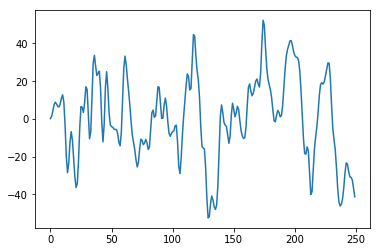

In [9]:
plt.plot(train_edss[113][0].T[0])

In [10]:
# train_edss_scaled = read.EdfStandardScaler(train_edss)
# valid_edss_scaled = read.EdfStandardScaler(valid_edss)

In [ ]:
%%bash
ls /home/ms994/v1.5.0/edf/train/01_tcp_ar/131/00013182/s001_2015_10_07/
cat /home/ms994/v1.5.0/edf/train/01_tcp_ar/131/00013182/s001_2015_10_07/00013182_s001.txt

In [ ]:
from keras_models.dataGen import EdfDataGenerator, RULEdfDataGenerator
import keras_models.dataGen as dg
reload(dg)

In [ ]:
train_edss.use_mp = False
valid_edss.use_mp = False
edg = dg.RULEdfDataGenerator(train_edss, n_classes=2, precache=False, batch_size=16, labels=[train_edss.sampleInfo[key].label for key in train_edss.sampleInfo.keys()])
valid_edg = dg.RULEdfDataGenerator(valid_edss, n_classes=2, precache=False, batch_size=16, labels=[valid_edss.sampleInfo[key].label for key in valid_edss.sampleInfo.keys()])

In [ ]:
test_edss.use_mp = False
test_edg = dg.EdfDataGenerator(test_edss, n_classes=2, precache=False, batch_size=32, shuffle=False)
test_labels = [test_edss.sampleInfo[key].label for key in test_edss.sampleInfo.keys()]

In [ ]:
seizureLabels = [train_edss.sampleInfo[key].label for key in train_edss.sampleInfo.keys()]

In [ ]:
train_edss.sampleInfo

## Simple NN setup

In [21]:
from keras_models.cnn_models import conv2d_gridsearch_pre_layers
from keras.layers import Input, Reshape, Dense, TimeDistributed, Dropout
from keras import Model
from keras.optimizers import Adam
pre_layer_h = 32
x = Input((1000, 21, 1)) #time, ecg channel, cnn channel
# y = x
y = Reshape((1000, 21))(x) #remove channel dim
y = TimeDistributed(Dense(pre_layer_h, activation="relu"))(y)
y = Reshape((1000, pre_layer_h, 1))(y) #add back in channel dim
_, y = conv2d_gridsearch_pre_layers(input_shape=(1000,21,1), dropout=0.25, x=y, num_conv_spatial_layers=2, num_spatial_filter=2, num_temporal_filter=0, num_conv_temporal_layers=0, max_pool_stride=(2,2), max_pool_size=(2,2), use_batch_normalization=True)
# y = Dense(30, activation="relu")(y)
y = Dropout(0.25)(y)
y_seizure = Dense(2, activation="softmax", name="seizure")(y)
model = Model(inputs=x, outputs=[y_seizure])


In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000, 21, 1)       0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1000, 21)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1000, 32)          704       
_________________________________________________________________
reshape_2 (Reshape)          (None, 1000, 32, 1)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1000, 32, 1)       4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1000, 32, 2)       20        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 500, 16, 2)        0         
__________

In [23]:
import pyedflib
reload(pyedflib)
reload(er)
reload(read)

<module 'data_reader' from '/home/ms994/dbmi_eeg_clustering/data_reader.py'>

In [25]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
mc = ModelCheckpoint("/n/scratch2/ms994/single_label.h5", monitor="val_binary_accuracy", save_best_only=True, verbose=True)
stopping = EarlyStopping("val_binary_accuracy", patience=50, verbose=True)

In [97]:
%%bash
ls /home/ms994

Miniconda3-latest-Linux-x86_64.sh
_about.txt
condaenv.7ds8vi6f.requirements.txt
dbmi_eeg_clustering
echo
env.yaml
filelist.out
get_files.sh
google-cloud-sdk
keras-cpu.err
miniconda3
multilabel.h5
nedc_pwd
ngrok
pyedflib
runtime_dir
sacred
secondDbmi
setup_env.sh
startJupyterNotebook.sh
test
test.py
testPredictSeizureData_4.pkl
testSeizureData.pkl
testSeizureData_4.pkl
trainPredictSeizureData_4.pkl
trainSeizureData.pkl
trainSeizureData_4.pkl
train_eeg_lengths.csv
tsfresh
v1.5.0
validPredictSeizureData_4.pkl
validSeizureData.pkl
validSeizureData_4.pkl
watch
~.bashrc


In [27]:
edg.dataset.use_mp = False
valid_edg.dataset.use_mp = False

model.compile("adam", loss=["binary_crossentropy"], metrics=["binary_accuracy"])
history = model.fit_generator(edg, validation_data=valid_edg, use_multiprocessing=True, max_queue_size=500000, workers=7, epochs=300, callbacks=[stopping])

In [6]:
from keras.models import load_model

In [18]:
model = load_model("/n/scratch2/ms994/single_label.h5")

In [20]:
len(test_edg.dataset)
test_edg.batch_size = 64

In [21]:
predictions = model.predict_generator(test_edg, use_multiprocessing=True, workers=8, max_queue_size=100000)

In [26]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report

In [23]:
accuracy_score(predictions.argmax(1), test_labels)

0.41893136630845845

In [24]:
f1_score(predictions.argmax(1), test_labels)

0.24708656374627633

In [25]:
roc_auc_score(predictions.argmax(1), test_labels)

0.5552546074766065

In [30]:
sum(test_labels)/ len(test_labels)

0.10630920732392257

In [28]:
print(classification_report(predictions.argmax(1), test_labels))

              precision    recall  f1-score   support

           0       0.36      0.97      0.53     44674
           1       0.90      0.14      0.25     88861

    accuracy                           0.42    133535
   macro avg       0.63      0.56      0.39    133535
weighted avg       0.72      0.42      0.34    133535



In [ ]:
plt.plot(history.history["binary_accuracy"])
plt.plot(history.history["val_binary_accuracy"])
plt.legend(["train", "validation"])
plt.show()

In [ ]:
valid_edg = dg.EdfDataGenerator(valid_edss, n_classes=2, precache=False, batch_size=16, shuffle=False, labels=[valid_edss.sampleInfo[key].label for key in valid_edss.sampleInfo.keys()])

In [ ]:
prediction = model.predict_generator(valid_edg, use_multiprocessing=True, workers=6, max_queue_size=100000,)

In [ ]:
prediction.sum(0)

In [ ]:
labels = valid_edg.labels

In [ ]:
predictionMax = prediction.argmax(1)

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, classification_report

In [ ]:
f1_score(predictionMax, labels)

In [ ]:
roc_auc_score(predictionMax, labels)

In [ ]:
accuracy_score(predictionMax, labels)

In [ ]:
print(classification_report(predictionMax, labels))

In [ ]:
len(labels) / 16

In [ ]:
labels[-5]

In [ ]:
valid_edg[3124][1]

# Try multi label approach?

In [ ]:
tkn_file_paths = [train_edss.sampleInfo[key].token_file_path for key in train_edss.sampleInfo.keys()]

In [ ]:
patients = [read.parse_edf_token_path_structure(tkn_file_path)[1] for tkn_file_path in tkn_file_paths]

In [33]:
allPatients = list(set(patients + [read.parse_edf_token_path_structure(valid_edss.sampleInfo[key].token_file_path)[1] for key in valid_edss.sampleInfo.keys()]))

In [34]:
patientInd = [allPatients.index(patient) for patient in patients]

In [35]:
validPatientInd = [allPatients.index(read.parse_edf_token_path_structure(valid_edss.sampleInfo[key].token_file_path)[1]) for key in valid_edss.sampleInfo.keys()]

In [36]:
seizureLabels = [train_edss.sampleInfo[key].label for key in train_edss.sampleInfo.keys()]
validSeizureLabels = [valid_edss.sampleInfo[key].label for key in valid_edss.sampleInfo.keys()]

In [37]:
for i in range(len(seizureLabels)):
    train_edss.sampleInfo[i].label = (seizureLabels[i], patientInd[i])

In [38]:
for i in range(len(validSeizureLabels)):
    valid_edss.sampleInfo[i].label = (validSeizureLabels[i], validPatientInd[i])

## Load cached multilabeled data

In [13]:
train_edss = pkl.load(open("/n/scratch2/ms994/train_multiple_labels_seizure_data_4.pkl", "rb"))
test_edss = pkl.load(open("/n/scratch2/ms994/test_multiple_labels_seizure_data_4.pkl", "rb"))

In [14]:
valid_edss = pkl.load(open("/n/scratch2/ms994/valid_multiple_labels_seizure_data_4.pkl", "rb"))


In [15]:
seizureLabels = [train_edss_datum[1][0] for train_edss_datum in train_edss]
patientInd = [train_edss_datum[1][1] for train_edss_datum in train_edss]
allPatients = list(set(patientInd))

In [16]:
validSeizureLabels = [valid_edss_datum[1][0] for valid_edss_datum in valid_edss]
validPatientInd = [valid_edss_datum[1][1] for valid_edss_datum in valid_edss]

In [17]:
train_edg = dg.RULEdfDataGenerator(train_edss, labels=seizureLabels, n_classes=2, precache=True)

In [18]:
valid_edg = dg.EdfDataGenerator(valid_edss, labels=validSeizureLabels, n_classes=2, precache=True)

In [108]:
testSeizureLabels = [test_edss_datum[1][0] for test_edss_datum in test_edss]
testPatientInd = [test_edss_datum[1][1] for test_edss_datum in test_edss]
test_edg = dg.EdfDataGenerator(test_edss, labels=testSeizureLabels, n_classes=2, precache=True)

In [4]:
reload(dg)
edg = dg.RULDataGenMultipleLabels(train_edss, num_labels=2, precache=True, labels=[seizureLabels, patientInd], xy_tuple_form=False, n_classes=(2, len(allPatients)), use_background_process=False)
# valid_edg = dg.RULDataGenMultipleLabels(valid_edss, num_labels=2, precache=True, labels=[validSeizureLabels, validPatientInd], xy_tuple_form=False, n_classes=(2, len(allPatients)), use_background_process=False)

## set up nn

In [5]:
from keras_models.cnn_models import conv2d_gridsearch_pre_layers
from keras.layers import Input, Reshape, Dense, TimeDistributed, Dropout
from keras import Model
from keras.optimizers import Adam
pre_layer_h = 512
x = Input((1000, 21, 1)) #time, ecg channel, cnn channel
y = Reshape((1000, 21))(x) #remove channel dim
y = TimeDistributed(Dense(pre_layer_h, activation="relu"))(y)
y = Reshape((1000, pre_layer_h, 1))(y) #add back in channel dim
_, y = conv2d_gridsearch_pre_layers(input_shape=(1000,21,1), dropout=0, x=y, num_conv_spatial_layers=3, num_conv_temporal_layers=3, num_spatial_filter=40, num_temporal_filter=80, max_pool_stride=(2,2), use_batch_normalization=True)
y = Dense(30, activation="relu")(y)
y = Dropout(0.5)(y)
y_seizure = Dense(2, activation="softmax", name="seizure")(y)
y_patient = Dense(len(allPatients), activation="softmax", name="patientId")(y)
model = Model(inputs=x, outputs=[y_seizure, y_patient])


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1000, 21, 1)  0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1000, 21)     0           input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 1000, 512)    11264       reshape_1[0][0]                  
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 1000, 512, 1) 0           time_distributed_1[0][0]         
__________________________________________________________________________________________________
conv2d_1 (

In [20]:
model.compile("adam", loss=["categorical_crossentropy", "categorical_crossentropy"], metrics=["categorical_accuracy"], loss_weights=[1,-1])

In [21]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
mc = ModelCheckpoint("/home/ms994/multilabel.h5", monitor="val_seizure_categorical_accuracy", save_best_only=True, verbose=True)
stopping = EarlyStopping("val_seizure_categorical_accuracy", patience=50, verbose=True)

In [ ]:
valid_batch = valid_edg[0]

In [ ]:
valid_batch

In [ ]:
edg.batch_size= 32

In [44]:
multi_label_history = model.fit_generator(edg, validation_data=valid_edg, use_multiprocessing=True, max_queue_size=500000, workers=7, epochs=100, callbacks=[mc, stopping])

Epoch 1/100
152/152 [==============================] - 176s 1s/step - loss: -13.2937 - seizure_loss: 2.0742 - patientId_loss: 15.3678 - seizure_categorical_accuracy: 0.6660 - patientId_categorical_accuracy: 0.0025 - val_loss: -11.3747 - val_seizure_loss: 1.8646 - val_patientId_loss: 13.2394 - val_seizure_categorical_accuracy: 0.5969 - val_patientId_categorical_accuracy: 0.0258

Epoch 00001: val_seizure_categorical_accuracy improved from -inf to 0.59688, saving model to /home/ms994/multilabel.h5
Epoch 2/100
152/152 [==============================] - 162s 1s/step - loss: -14.7981 - seizure_loss: 1.1160 - patientId_loss: 15.9141 - seizure_categorical_accuracy: 0.7046 - patientId_categorical_accuracy: 6.1679e-04 - val_loss: -13.1635 - val_seizure_loss: 1.2240 - val_patientId_loss: 14.3875 - val_seizure_categorical_accuracy: 0.6181 - val_patientId_categorical_accuracy: 0.0035

Epoch 00002: val_seizure_categorical_accuracy improved from 0.59688 to 0.61806, saving model to /home/ms994/multila

Process ForkPoolWorker-236:
Process ForkPoolWorker-237:
Process ForkPoolWorker-238:
Process ForkPoolWorker-230:
Process ForkPoolWorker-231:
Process ForkPoolWorker-229:
Process ForkPoolWorker-227:
Process ForkPoolWorker-225:
Process ForkPoolWorker-228:
Process ForkPoolWorker-232:
Process ForkPoolWorker-226:
Process ForkPoolWorker-233:
Process ForkPoolWorker-234:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ms994/miniconda3/envs/ker

  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ms994/dbmi_eeg_clustering/keras_models/dataGen.py", line 250, in __getitem__
    X, y = self.__data_generation(list_IDs_temp)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/ms994/dbmi_eeg_clustering/keras_models/dataGen.py", line 250, in __getitem__
    X, y = self.__data_generation(list_IDs_temp)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/ms994/dbmi_eeg_clustering/keras_models/dataGen.py", line 291, in __data_generation
    x, labels = self.g

  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/internals/construction.py", line 265, in _homogenize
    val = val.reindex(index, copy=False)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/frame.py", line 6487, in apply
    return op.get_result()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/frame.py", line 6487, in apply
    return op.get_result()
KeyboardInterrupt
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/apply.py", line 151, in get_result
    return self.apply_standard()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/apply.py", line 151, in get_result
    return self.apply_standard()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/apply.py", line 257, in apply_standard
    self.apply_series_generator()
  File "/home/ms994/miniconda3/envs/keras

KeyboardInterrupt: 

In [45]:
model = load_model("/home/ms994/multilabel.h5")

In [46]:
predictions = model.predict_generator(test_edg, use_multiprocessing=True, workers=8, max_queue_size=100000)

In [53]:
sum(test_labels)/len(test_labels)

0.10630920732392257

In [56]:
print(classification_report(predictions[0].argmax(1), test_labels))

              precision    recall  f1-score   support

           0       0.28      0.97      0.43     34174
           1       0.92      0.13      0.23     99361

    accuracy                           0.35    133535
   macro avg       0.60      0.55      0.33    133535
weighted avg       0.75      0.35      0.28    133535



In [57]:
accuracy_score(predictions[0].argmax(1), test_labels)

0.34507806942000224

In [58]:
f1_score(predictions[0].argmax(1), test_labels)

0.22985813292003135

In [59]:
sum(predictions[0].argmax(1))

99361

In [60]:
sum(predictions[0].argmax(1))/len(predictions[0].argmax(1))

0.7440820758602613

# Try 3d cnn?

In [15]:
8**3

512

In [32]:
from keras_models.cnn_models import conv2d_gridsearch_pre_layers
from keras.layers import Input, Reshape, Dense, TimeDistributed, Dropout, Conv3D, BatchNormalization, MaxPool3D, Flatten
from keras import Model
from keras.optimizers import Adam
pre_layer_h = 24
x = Input((1000, 21, 1)) #time, ecg channel, cnn channel
y = Reshape((1000, 21))(x) #remove channel dim
y = TimeDistributed(Dense(pre_layer_h**2, activation="relu"))(y)
y = Reshape((1000, pre_layer_h,pre_layer_h, 1))(y) #add back in channel dim


In [33]:
for i in range(2):
    y = BatchNormalization()(y)
    y = Conv3D(10, (3,3,3), activation="relu")(y)
    y = MaxPool3D()(y)

In [34]:
y = Flatten()(y)
y_seizure = Dense(2, activation="softmax", name="seizure")(y)
model = Model(inputs=x, outputs=[y_seizure])

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1000, 21, 1)       0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 1000, 21)          0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1000, 576)         12672     
_________________________________________________________________
reshape_6 (Reshape)          (None, 1000, 24, 24, 1)   0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 1000, 24, 24, 1)   4         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 998, 22, 22, 10)   280       
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 499, 11, 11, 10)   0         
__________

In [36]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
mc = ModelCheckpoint("/n/scratch2/ms994/3d_test.h5", monitor="val_binary_accuracy", save_best_only=True, verbose=True)
stopping = EarlyStopping("val_binary_accuracy", patience=50, verbose=True)


In [37]:
from keras.optimizers import Adam

In [38]:
from keras.utils import multi_gpu_model
model = multi_gpu_model(model, 2)
model.compile("adam", loss=["binary_crossentropy"], metrics=["binary_accuracy"])
history = model.fit_generator(edg, validation_data=valid_edg, use_multiprocessing=True, max_queue_size=500000, workers=8, epochs=30, callbacks=[stopping, mc])

Epoch 1/30
310/310 [==============================] - 84s 271ms/step - loss: 4.2705 - binary_accuracy: 0.5790 - val_loss: 8.0151 - val_binary_accuracy: 0.5000

Epoch 00001: val_binary_accuracy improved from -inf to 0.50000, saving model to /n/scratch2/ms994/3d_test.h5


Process ForkPoolWorker-229:
Process ForkPoolWorker-226:
Process ForkPoolWorker-236:
Process ForkPoolWorker-235:
Process ForkPoolWorker-238:
Process ForkPoolWorker-232:
Process ForkPoolWorker-230:
Process ForkPoolWorker-225:
Process ForkPoolWorker-239:
Process ForkPoolWorker-231:
Process ForkPoolWorker-227:
Process ForkPoolWorker-234:
Process ForkPoolWorker-237:
Process ForkPoolWorker-233:
Traceback (most recent call last):
Process ForkPoolWorker-228:
Traceback (most recent call last):
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 99, i

  File "/home/ms994/dbmi_eeg_clustering/ensembleReader.py", line 282, in __getitem__
    max_length=self.gap)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ms994/dbmi_eeg_clustering/keras_models/dataGen.py", line 147, in get_x_y
    data = self.dataset[i]
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/keras/utils/data_utils.py", line 401, in get_index
    return _SHARED_SEQUENCES[uid][i]
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/keras/utils/data_utils.py", line 401, in get_index
    return _SHARED_SEQUENCES[uid][i]
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs

  File "/home/ms994/dbmi_eeg_clustering/util_funcs.py", line 91, in getItemSlice
    toReturn[i] = self[j]
KeyboardInterrupt
  File "/home/ms994/dbmi_eeg_clustering/util_funcs.py", line 91, in getItemSlice
    toReturn[i] = self[j]
  File "/home/ms994/dbmi_eeg_clustering/keras_models/dataGen.py", line 147, in get_x_y
    data = self.dataset[i]
  File "/home/ms994/dbmi_eeg_clustering/ensembleReader.py", line 274, in __getitem__
    return self.getItemSlice(i)
  File "/home/ms994/dbmi_eeg_clustering/keras_models/dataGen.py", line 167, in __getitem__
    X, y = self.__data_generation(list_IDs_temp)
  File "/home/ms994/dbmi_eeg_clustering/keras_models/dataGen.py", line 147, in get_x_y
    data = self.dataset[i]
  File "/home/ms994/dbmi_eeg_clustering/keras_models/dataGen.py", line 175, in __data_generation
    x, y = self.get_x_y(list_IDs_temp)
  File "/home/ms994/dbmi_eeg_clustering/keras_models/dataGen.py", line 175, in __data_generation
    x, y = self.get_x_y(list_IDs_temp)
  File "/ho

  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/reshape/concat.py", line 229, in concat
    return op.get_result()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/apply.py", line 151, in get_result
    return self.apply_standard()


KeyboardInterrupt: 

  File "/home/ms994/dbmi_eeg_clustering/ensembleReader.py", line 296, in __getitem__
    axis=0)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/indexes/base.py", line 4455, in get_indexer_for
    return self.get_indexer(target, **kwargs)
  File "/home/ms994/dbmi_eeg_clustering/ensembleReader.py", line 274, in __getitem__
    return self.getItemSlice(i)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/frame.py", line 2867, in _ixs
    label = self.columns[i]
  File "/home/ms994/dbmi_eeg_clustering/ensembleReader.py", line 274, in __getitem__
    return self.getItemSlice(i)
  File "/home/ms994/dbmi_eeg_clustering/data_reader.py", line 638, in edf_eeg_2_df
    periods=len(signal_data)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/apply.py", line 257, in apply_standard
    self.apply_series_generator()
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packa

  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/tseries/offsets.py", line 2310, in delta
    return self.n * self._inc
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/series.py", line 3738, in reindex
    return super(Series, self).reindex(index=index, **kwargs)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/internals/construction.py", line 212, in init_dict
    return arrays_to_mgr(arrays, data_names, index, columns, dtype=dtype)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/apply.py", line 286, in apply_series_generator
    results[i] = self.f(v)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/scipy/signal/filter_design.py", line 1105, in zpk2tf
    b = k * poly(z)
  File "/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/pandas/core/internals/managers.py", line 1666, in create_block_manag

# Try 2d cnn with domain adaptation

In [16]:
read.parse_edf_token_path_structure(tkn_file_paths[0])

NameError: name 'tkn_file_paths' is not defined

In [125]:
tkn_file_paths = [train_edss.sampleInfo[key].token_file_path for key in train_edss.sampleInfo.keys()]

In [126]:
patients = [read.parse_edf_token_path_structure(tkn_file_path)[1] + "/" + read.parse_edf_token_path_structure(tkn_file_path)[2]  for tkn_file_path in tkn_file_paths]

In [127]:
allPatients = list(set(patients))

In [128]:
patientInd = [allPatients.index(patient) for patient in patients]

In [129]:
# validPatientInd = [allPatients.index(read.parse_edf_token_path_structure(valid_edss.sampleInfo[key].token_file_path)[1]) for key in valid_edss.sampleInfo.keys()]

In [130]:
validPatientInd = [1 for i in valid_edss.sampleInfo.keys()] #set to 1, this should never be accurate anyways

In [131]:
seizureLabels = [train_edss.sampleInfo[key].label for key in train_edss.sampleInfo.keys()]
validSeizureLabels = [valid_edss.sampleInfo[key].label for key in valid_edss.sampleInfo.keys()]

In [132]:
for i in range(len(seizureLabels)):
    train_edss.sampleInfo[i].label = (seizureLabels[i], patientInd[i])

In [133]:
for i in range(len(validSeizureLabels)):
    valid_edss.sampleInfo[i].label = (validSeizureLabels[i], validPatientInd[i])

In [134]:
len(allPatients)

559

## Set up the data generators

In [92]:
train_edss.use_mp
valid_edss.use_mp

AttributeError: 'list' object has no attribute 'use_mp'

In [26]:
reload(dg)
edg = dg.RULDataGenMultipleLabels(train_edss, num_labels=2, labels=[seizureLabels, patientInd], xy_tuple_form=True, n_classes=(2, len(allPatients)), use_background_process=False, precache=True, batch_size=32)
valid_edg = dg.RULDataGenMultipleLabels(valid_edss, num_labels=2, labels=[validSeizureLabels, validPatientInd], xy_tuple_form=True, n_classes=(2, len(allPatients)), shuffle=False, use_background_process=False, precache=True, batch_size=64)

In [108]:
seizureLabels

[(False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (False, 10),
 (Fals

In [6]:
test_edg = dg.EdfDataGenerator(test_edss)

In [138]:
read.file_list

set()

In [7]:
from keras.utils import GeneratorEnqueuer, OrderedEnqueuer

In [8]:
train_ordered_enqueuer = OrderedEnqueuer(edg, True)
valid_ordered_enqueuer = OrderedEnqueuer(valid_edg, True)

## set up 2d nn

In [9]:
from keras_models.cnn_models import conv2d_gridsearch_pre_layers
from keras.layers import Input, Reshape, Dense, MaxPool2D, TimeDistributed, Dropout, Conv3D, Conv2D, BatchNormalization, MaxPool3D, Flatten
from keras import Model
from keras.optimizers import Adam
pre_layer_h = 64
x = Input((1000, 21, 1)) #time, ecg channel, cnn channel
y = Reshape((1000, 21))(x) #remove channel dim
y = TimeDistributed(Dense(pre_layer_h, activation="relu"))(y)
y = Reshape((1000, pre_layer_h, 1))(y) #add back in channel dim


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


In [10]:
y = BatchNormalization()(y)
y = Conv2D(3, (4,2), activation="relu")(y)
y = MaxPool2D((2,1))(y)
y = BatchNormalization()(y)
y = Conv2D(3, (4,2), activation="relu")(y)
y = MaxPool2D((2,1))(y)
y = BatchNormalization()(y)
y = Conv2D(3, (4,2), activation="relu")(y)
y = MaxPool2D((2,1))(y)
y = BatchNormalization()(y)
y = Conv2D(3, (3,3), activation="relu")(y)
y = MaxPool2D()(y)
y = BatchNormalization()(y)
y = Conv2D(3, (3,3), activation="relu")(y)
y = MaxPool2D()(y)
y = BatchNormalization()(y)
y = Conv2D(3, (3,3), activation="relu")(y)
y = MaxPool2D()(y)
y = BatchNormalization()(y)
y = Flatten()(y)


In [11]:
y_seizure = Dense(2, activation="softmax", name="seizure")(y)
y_patient = Dense(len(allPatients), activation="softmax", name="patient")(y)
model = Model(inputs=x, outputs=[y_seizure, y_patient])

In [12]:
seizure_model = Model(inputs=x, outputs=[y_seizure])

In [13]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1000, 21, 1)  0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1000, 21)     0           input_1[0][0]                    
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 1000, 64)     1408        reshape_1[0][0]                  
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 1000, 64, 1)  0           time_distributed_1[0][0]         
__________________________________________________________________________________________________
batch_norm

In [17]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
mc = ModelCheckpoint("/n/scratch2/ms994/3d_test.h5", monitor="val_binary_accuracy", save_best_only=True, verbose=True)
stopping = EarlyStopping("val_binary_accuracy", patience=50, verbose=True)


In [18]:
from keras.optimizers import Adam

In [14]:
from keras.utils import multi_gpu_model
# model = multi_gpu_model(model, 2)
model.compile(Adam(lr=0.005), loss=["binary_crossentropy", "categorical_crossentropy"], loss_weights=[5,0], metrics=["categorical_accuracy"])
# history = model.fit_generator(edg, validation_data=validEdg, use_multiprocessing=True, max_queue_size=500000, workers=7, epochs=300, callbacks=[stopping, mc])

In [15]:
patient_model = Model(inputs=x, outputs=[y_patient])
patient_model.compile(Adam(lr=0.005), loss=["binary_crossentropy"], metrics=["categorical_accuracy"])

In [21]:
layers = patient_model.layers[-1].weights

In [86]:
model.layers[-1].name

'patient'

In [16]:
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, classification_report

In [17]:
model.metrics_names, patient_model.metrics_names

(['loss',
  'seizure_loss',
  'patient_loss',
  'seizure_categorical_accuracy',
  'patient_categorical_accuracy'],
 ['loss', 'categorical_accuracy'])

## Run the batches

In [154]:
read.file_list_lock

<Lock(owner=None)>

In [155]:
read.file_list

set()

In [156]:
edg.dataset.use_mp

False

In [24]:
train_ordered_enqueuer.start(workers=2, max_queue_size=10)
train_ordered_enqueuer.stop()

In [21]:
generator = train_ordered_enqueuer.get()

In [159]:
valid_edg

In [ ]:
from IPython.display import clear_output
toKeep = ""
num_epochs = 10
training_seizure_accs = []
test_seizure_accs = []
oldPatientWeights = model.layers[-1].get_weights()
oldNonPatientWeights = [layer.get_weights() for layer in model.layers[:-1]]
best_model_acc = -100

for i in range(num_epochs):
#     edg.start_background()
    

    valid_labels = []
    valid_predictions = []

    seizure_accs = []
    patient_accs = []
    train_ordered_enqueuer.start(workers=8, max_queue_size=1000)
    train_generator = train_ordered_enqueuer.get()
    for j in range(len(edg)):
        train_batch = next(train_generator)
        loss, seizure_loss, patient_loss, seizure_acc, patient_acc = model.train_on_batch(train_batch[0], train_batch[1])
        seizure_accs.append(seizure_acc)
        #old patient weights are trying to predict for patient, try to do the prediction!
        model.layers[-1].set_weights(oldPatientWeights)
        #keep the other nonpatient weights which try not to predict for patient!
        oldNonPatientWeights = [layer.get_weights() for layer in model.layers[:-1]]
        patient_loss, patient_acc = patient_model.train_on_batch(train_batch[0], train_batch[1][1])
        patient_accs.append(patient_acc)

        #get weights that try to predict for patient
        oldPatientWeights = patient_model.layers[-1].get_weights()

        #set weights that don't ruin seizure prediction
        for layer_num, layer in enumerate(model.layers[:-1]):
            model.layers[layer_num].set_weights(oldNonPatientWeights[layer_num])
        if (j % 5) == 0:
            clear_output()
            print(toKeep)
            print("epoch: {} batch: {}/{}, seizure acc: {}, patient acc: {}".format(i, j, len(edg), np.mean(seizure_accs), np.mean(patient_accs)))
#     valid_edg.start_background()
    valid_ordered_enqueuer.start(workers=8, max_queue_size=100000)
    valid_generator = valid_ordered_enqueuer.get()

    for j in range(len(edg)):
        valid_batch = next(valid_generator)
        val_batch_predictions = model.predict_on_batch(valid_batch[0])
        valid_labels.append(valid_batch[1][0].argmax(1))
        valid_predictions.append(val_batch_predictions[0].argmax(1))
    valid_ordered_enqueuer.stop()
    valid_labels = np.hstack(valid_labels)
    val_predictions = np.hstack(valid_predictions)
    try:
        auc = roc_auc_score(val_predictions, valid_labels)
    except Exception:
        auc = "undefined"
    test_acc =  accuracy_score(val_predictions, valid_labels)
    test_seizure_accs.append(test_acc)
    toKeep += ("end epoch: {}, f1: {}, auc: {}, acc: {}\n".format(i, f1_score(val_predictions, valid_labels), auc, test_acc))
    if (test_acc > best_model_acc):
        best_model_acc = test_acc
        try:
            model.save("/n/scratch2/ms994/best_domain_adapt.h5")
            toKeep += ("improved val score from {}".format(best_model_acc))
        except Exception as e:
            toKeep += ("{}\n".format(e))
            toKeep += ("failed saving\n")
    print(toKeep)



    training_seizure_accs.append(np.mean(seizure_accs))
    train_ordered_enqueuer.stop()

    edg.on_epoch_end()
plt.plot(training_seizure_accs)
plt.plot(test_seizure_accs)
plt.legend(["train", "valid"])
plt.xlabel("num epochs")
plt.ylabel("acc")
plt.show()
train_ordered_enqueuer.stop()
valid_ordered_enqueuer.stop()

end epoch: 0, f1: 0.6714034470629617, auc: 0.615090537557392, acc: 0.530316742081448
improved val score from 0.530316742081448end epoch: 1, f1: 0.6966790750554711, auc: 0.6865733486366148, acc: 0.5841880341880342
improved val score from 0.5841880341880342end epoch: 2, f1: 0.6497576805653408, auc: 0.6002029516997429, acc: 0.5876068376068376
improved val score from 0.5876068376068376end epoch: 3, f1: 0.7210094046555172, auc: 0.6963794362993664, acc: 0.6703871292106586
improved val score from 0.6703871292106586
epoch: 4 batch: 45/1245, seizure acc: 0.86548912525177, patient acc: 0.348505437374115


In [ ]:
train_ordered_enqueuer.stop()
valid_ordered_enqueuer.stop()

In [ ]:
toKeep

In [ ]:
next(generator.get())

In [ ]:
for j in range(len(valid_edg)):
        valid_batch = valid_edg[j]
        val_batch_predictions = model.predict_on_batch(valid_batch[0])
        valid_labels.append(valid_batch[1][0].argmax(1))
        valid_predictions.append(val_batch_predictions[0].argmax(1))
valid_labels = np.hstack(valid_labels)
val_predictions = np.hstack(valid_predictions)
try:
    auc = roc_auc_score(val_predictions, valid_labels)
except Exception:
    auc = "undefined"
test_acc =  accuracy_score(val_predictions, valid_labels)
test_seizure_accs.append(test_acc)
toKeep += ("end epoch: {}, f1: {}, auc: {}, acc: {}\n".format(i, f1_score(val_predictions, valid_labels), auc, test_acc))
print(toKeep)
training_seizure_accs.append(np.mean(seizure_accs))
edg.on_epoch_end()

In [ ]:
model.save("/n/scratch2/ms994/domain_adapt.h5")

## Pull the best model and test it

In [16]:
from keras.models import load_model

In [17]:
model = load_model("/n/scratch2/ms994/domain_adapt.h5")

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


In [18]:
test_edss.use_mp = False
test_edss.n_workers = 1
test_edg = dg.EdfDataGenerator(test_edss, n_classes=2, precache=False, batch_size=32, shuffle=False)
test_labels = [test_edss.sampleInfo[key].label for key in test_edss.sampleInfo.keys()]

In [19]:
len(test_edg)

16634

In [20]:
predictions = model.predict_generator(test_edg, use_multiprocessing=True, workers=12, max_queue_size=100000)

In [25]:
predictions

[array([[0.9940692 , 0.00593086],
        [0.98968   , 0.01031997],
        [0.98416704, 0.01583293],
        ...,
        [0.9847438 , 0.01525624],
        [0.98753256, 0.01246743],
        [0.97807455, 0.02192545]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)]

In [26]:
print(f1_score(predictions[0].argmax(1), test_labels))

0.06366831054543307


In [27]:
print(accuracy_score(predictions[0].argmax(1), test_labels))

0.8808625600252501


In [28]:
print(classification_report(predictions[0].argmax(1), test_labels))

              precision    recall  f1-score   support

           0       0.98      0.90      0.94    521271
           1       0.04      0.20      0.06     11005

    accuracy                           0.88    532276
   macro avg       0.51      0.55      0.50    532276
weighted avg       0.96      0.88      0.92    532276



In [29]:
print(roc_auc_score(predictions[0].argmax(1), test_labels))

0.545617055804426


In [31]:
predictions[0].argmax(1).sum() / len(predictions[0])

0.02067536390894949

# set up another nn with dense between cnn

In [77]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [91]:
from keras_models.cnn_models import conv2d_gridsearch_pre_layers, inception_like_layer
from keras.layers import Input, Reshape, Dense, TimeDistributed, Dropout, MaxPool2D, Conv2D, Flatten, GaussianNoise
from keras import Model
from keras.optimizers import Adam
pre_layer_h = 21
x = Input((1000, 21, 1)) #time, ecg channel, cnn channel
y = GaussianNoise(0.5)(x)
y = Reshape((1000, 21))(y) #remove channel dim
y = TimeDistributed(Dense(pre_layer_h, activation="relu"))(y)
y = Reshape((1000, pre_layer_h, 1))(y) #add back in channel dim

In [92]:
for i in range(2):
    y = Conv2D(1, (4,4), activation="relu")(y)
    y = MaxPool2D((2,1))(y)
    
for i in range(2):
    y = Conv2D(1, (4,4), activation="relu")(y)
    y = MaxPool2D((2,1))(y)    
    y = TimeDistributed(Dense(y.get_shape()[2].value, activation="relu"))(y)
    y = TimeDistributed(Dense(y.get_shape()[2].value, activation="relu"))(y)
#     y = TimeDistributed(Dense(y.get_shape()[2].value, activation="relu"))(y)

#     y = TimeDistributed(Dropout(0.25))(y)
#     y = TimeDistributed(Dense(pre_layer_h, activation="relu"))(y)
# for i in range(3):
#     y = inception_like_layer(y, 1)
#     y = MaxPool2D((2,2))(y)
#     y = TimeDistributed(Dense(pre_layer_h, activation="relu"))(y)
#     y = TimeDistributed(Dropout(0.25))(y)
#     y = TimeDistributed(Dense(pre_layer_h, activation="relu"))(y)
y = Flatten()(y)
y = Dense(2)(y)

2

In [93]:
model = Model(input=x, outputs=[y])

/home/ms994/miniconda3/envs/keras-redo/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`
  """Entry point for launching an IPython kernel.


In [94]:
model.compile("adam", loss="binary_crossentropy", metrics=["binary_accuracy", f1_m,precision_m, recall_m],)

In [95]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 1000, 21, 1)       0         
_________________________________________________________________
gaussian_noise_11 (GaussianN (None, 1000, 21, 1)       0         
_________________________________________________________________
reshape_21 (Reshape)         (None, 1000, 21)          0         
_________________________________________________________________
time_distributed_113 (TimeDi (None, 1000, 21)          462       
_________________________________________________________________
reshape_22 (Reshape)         (None, 1000, 21, 1)       0         
_________________________________________________________________
conv2d_207 (Conv2D)          (None, 997, 18, 1)        17        
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 498, 18, 1)        0         
__________

In [96]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
mc = ModelCheckpoint("/home/ms994/test.h5", monitor="val_f1_m", mode="max", save_best_only=True, verbose=True)
stopping = EarlyStopping("val_loss", patience=10, verbose=True,)
reduceLR = ReduceLROnPlateau(cooldown=1, patience=5)

In [58]:
valid_batch = valid_edg[0]

In [99]:
valid_batch[1].

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [100]:
train_edg.batch_size= 128

In [101]:
multi_label_history = model.fit_generator(train_edg, validation_data=valid_edg, epochs=1000, callbacks=[mc, stopping, reduceLR])

Epoch 1/1000
293/293 [==============================] - 33s 114ms/step - loss: 0.7760 - binary_accuracy: 0.5643 - f1_m: 0.5359 - precision_m: 0.5661 - recall_m: 0.5555 - val_loss: 0.5413 - val_binary_accuracy: 0.6874 - val_f1_m: 0.6723 - val_precision_m: 0.7052 - val_recall_m: 0.6433

Epoch 00001: val_f1_m improved from -inf to 0.67229, saving model to /home/ms994/test.h5
Epoch 2/1000
293/293 [==============================] - 29s 99ms/step - loss: 0.6042 - binary_accuracy: 0.6979 - f1_m: 0.6992 - precision_m: 0.6980 - recall_m: 0.7123 - val_loss: 0.4924 - val_binary_accuracy: 0.7715 - val_f1_m: 0.7671 - val_precision_m: 0.7818 - val_recall_m: 0.7535

Epoch 00002: val_f1_m improved from 0.67229 to 0.76710, saving model to /home/ms994/test.h5
Epoch 3/1000
293/293 [==============================] - 30s 101ms/step - loss: 0.5613 - binary_accuracy: 0.7286 - f1_m: 0.7204 - precision_m: 0.7392 - recall_m: 0.7101 - val_loss: 0.5122 - val_binary_accuracy: 0.7804 - val_f1_m: 0.7842 - val_precis

In [106]:
from keras.models import load_model
model = load_model("/home/ms994/test.h5", compile=False)

In [109]:
predictions = model.predict_generator(test_edg)

In [111]:
sum(testSeizureLabels)/len(testSeizureLabels)

0.1475078273190575

In [114]:
from sklearn.metrics import classification_report, accuracy_score, f1_score
print(classification_report(predictions.argmax(1), testSeizureLabels))

              precision    recall  f1-score   support

           0       0.60      0.85      0.70     52238
           1       0.40      0.15      0.21     35276

    accuracy                           0.57     87514
   macro avg       0.50      0.50      0.46     87514
weighted avg       0.52      0.57      0.51     87514



In [ ]:
predictions[0].argmax(1).shape

In [ ]:
accuracy_score(predictions[0].argmax(1), test_labels)

In [58]:
f1_score(predictions[0].argmax(1), test_labels)

0.22985813292003135

In [59]:
sum(predictions[0].argmax(1))

99361

In [60]:
sum(predictions[0].argmax(1))/len(predictions[0].argmax(1))

0.7440820758602613

# Compare 2d CNN vs 3D cnn autoencoder

In [3]:
%%bash
ls -lah /n/scratch2/ms994

total 150G
drwxrwxr-x    6 ms994 ms994  12K Dec 25 12:58 .
drwxrwxrwx 1759 root  root  2.6M Dec 26 15:57 ..
drwxrwxr-x    2 ms994 ms994 4.0K Dec 13 03:50 bak
-rw-rw-r--    1 ms994 ms994 802M Nov 24 13:29 debug_test_multiple_labels_seizure_data_4.pkl
-rw-rw-r--    1 ms994 ms994 802M Nov 24 13:29 debug_train_multiple_labels_seizure_data_4.pkl
-rw-rw-r--    1 ms994 ms994 802M Nov 24 13:29 debug_valid_multiple_labels_seizure_data_4.pkl
-rw-rw-r--    1 ms994 ms994  21G Dec 25 13:46 gnfncp_test_multiple_labels_sessions_seizure_data_4.pkl
-rw-rw-r--    1 ms994 ms994  33G Dec 25 13:44 gnfncp_train_multiple_labels_sessions_seizure_data_4.pkl
-rw-rw-r--    1 ms994 ms994  18G Dec 25 13:45 gnfncp_valid_multiple_labels_sessions_seizure_data_4.pkl
drwxrwxr-x    2 ms994 ms994 356K Dec 26 03:14 out
-rw-rw-r--    1 ms994 ms994  86M Dec 25 13:01 seizure_multi_labels_edss_info.pkl
-rw-rw-r--    1 ms994 ms994 1.7M Nov 24 12:17 test_model
-rw-rw-r--    1 ms994 ms994  14G Nov 20 11:43 test_multiple_labels_s

In [4]:
len(train_edss)

137903

In [3]:
data_x = np.array([train_edss[i][0] for i in range(5000)])
# data_x = np.concatenate(data_x, np.array([train_edss[i][0] for i in range(70000)]))


In [4]:
del train_edss

In [11]:
data_x.shape

(70000, 1000, 21)

## Try 3d CNN

In [130]:
from keras_models.cnn_models import conv2d_gridsearch_pre_layers
from keras.layers import Input, Reshape, Dense, TimeDistributed, Dropout, Conv3D, BatchNormalization, MaxPool3D, Flatten, GaussianNoise, UpSampling3D, Lambda
from keras import Model
from keras.optimizers import Adam
pre_layer_h = 16
x = Input((1000, 21)) #time, ecg channel, 
# y = GaussianNoise(5)(x)
y = TimeDistributed(Dense(pre_layer_h**2, activation="linear"))(x)
y = Reshape((1000, pre_layer_h,pre_layer_h, 1))(y) #add back in channel dim

In [131]:
for i in range(4):
    y = BatchNormalization()(y)
    y = Conv3D(2**i, (4,4,4), activation="relu", padding="same")(y)
    y = MaxPool3D((2, 1, 1), padding="same")(y)
    
for i in range(2):
    y = BatchNormalization()(y)
    y = Conv3D(2**(i+4), (3,3,3), activation="relu", padding="same")(y)
    y = MaxPool3D((2, 2, 2), padding="same")(y)

In [64]:
# encoded = Dense(8**3)(Flatten()(y))
# y = Reshape((8, 8, 8))(encoded)

In [132]:
for i in range(2):
    y = BatchNormalization()(y)
    y = Conv3D(2**(5 - i), (3,3,3), activation="relu", padding="same")(y)
    y = UpSampling3D((2, 2, 2))(y)
    
for i in range(4):
    y = BatchNormalization()(y)
    y = Conv3D(2**(3-i), (4,4,4), activation="relu", padding="same")(y)
    y = UpSampling3D((2, 1, 1))(y)

In [133]:
y = Reshape((1024, pre_layer_h **2))(y)
y = TimeDistributed(Dense(21, activation="linear"))(y)

In [134]:
y = Lambda(lambda x: x[:, 12:1012], output_shape=(1000,21))(y)

In [135]:
model = Model(inputs=x, outputs=y)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 1000, 21)          0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 1000, 256)         5632      
_________________________________________________________________
reshape_17 (Reshape)         (None, 1000, 16, 16, 1)   0         
_________________________________________________________________
batch_normalization_71 (Batc (None, 1000, 16, 16, 1)   4         
_________________________________________________________________
conv3d_71 (Conv3D)           (None, 1000, 16, 16, 1)   65        
_________________________________________________________________
max_pooling3d_36 (MaxPooling (None, 500, 16, 16, 1)    0         
_________________________________________________________________
batch_normalization_72 (Batc (None, 500, 16, 16, 1)    4         
__________

In [136]:
from keras import optimizers

In [142]:
model.compile(optimizer=optimizers.Adam(lr=0.001), loss="mean_squared_error",)

In [144]:
import keras.callbacks as cb
model.fit(data_x[0:1000], data_x[0:1000], batch_size=32, epochs=100, callbacks=[cb.LearningRateScheduler(lambda lr: lr*0.5)])

Epoch 1/100
1000/1000 [==============================] - 38s 38ms/step - loss: 12519.8997
Epoch 2/100
1000/1000 [==============================] - 38s 38ms/step - loss: 12519.8856
Epoch 3/100
1000/1000 [==============================] - 38s 38ms/step - loss: 12519.7073
Epoch 4/100
1000/1000 [==============================] - 38s 38ms/step - loss: 12519.7488
Epoch 5/100
1000/1000 [==============================] - 38s 38ms/step - loss: 12520.1589
Epoch 6/100
1000/1000 [==============================] - 38s 38ms/step - loss: 12519.7731
Epoch 7/100
1000/1000 [==============================] - 38s 38ms/step - loss: 12519.9092
Epoch 8/100
1000/1000 [==============================] - 38s 38ms/step - loss: 12519.8076
Epoch 9/100
1000/1000 [==============================] - 38s 38ms/step - loss: 12520.0714
Epoch 10/100
1000/1000 [==============================] - 38s 38ms/step - loss: 12520.1430
Epoch 11/100
1000/1000 [==============================] - 38s 38ms/step - loss: 12519.9874
Epoch 12

KeyboardInterrupt: 

In [95]:
model.compile(optimizer=optimizers.Adam(lr=0.001), loss="mean_squared_error")
model.fit(data_x[0:1000], data_x[0:1000], batch_size=64, epochs=10)

Epoch 1/10
1000/1000 [==============================] - 30s 30ms/step - loss: 10252.0820
Epoch 2/10
1000/1000 [==============================] - 18s 18ms/step - loss: 9804.8523
Epoch 3/10
1000/1000 [==============================] - 18s 18ms/step - loss: 9860.0697
Epoch 4/10
1000/1000 [==============================] - 18s 18ms/step - loss: 9945.9150
Epoch 5/10
1000/1000 [==============================] - 18s 18ms/step - loss: 9819.6136
Epoch 6/10
1000/1000 [==============================] - 18s 18ms/step - loss: 9945.9986
Epoch 7/10
1000/1000 [==============================] - 18s 18ms/step - loss: 9698.5559
Epoch 8/10
1000/1000 [==============================] - 18s 18ms/step - loss: 9568.8256
Epoch 9/10
1000/1000 [==============================] - 18s 18ms/step - loss: 9779.8956
Epoch 10/10
1000/1000 [==============================] - 18s 18ms/step - loss: 9935.3519


In [96]:
from keras import backend as K
sess = K.get_session()
with sess.as_default():
    translate = model.layers[2].layer.weights[0].eval()

In [97]:
mapping = translate.reshape((21, 16, 16)).argmax(axis=0)

In [98]:
mapping

array([[16, 16,  9,  1, 18,  9,  9, 16, 16,  9,  6,  8,  8,  1,  1, 16],
       [16, 20,  1,  9,  1,  9,  2,  1,  9,  9,  8,  8,  1,  1, 14, 16],
       [16,  6,  6, 17, 15,  6,  9,  9,  6,  9,  3,  6,  1, 16, 16,  1],
       [ 6,  6,  3,  4,  6,  8,  9,  6, 18,  9,  3,  4, 15,  3,  1,  1],
       [ 6, 15,  1,  4,  4, 13,  6,  9, 20,  6,  9, 16,  6,  8,  7, 16],
       [16, 17,  8,  8, 18,  9, 16,  8,  8,  4, 16, 16,  4,  8, 19,  4],
       [10,  9,  8, 12,  4,  4,  4,  8,  4,  4, 16,  4,  4, 10,  0, 16],
       [ 9,  1, 15,  8,  8,  4, 14, 19,  8, 13,  6,  4,  4, 16, 16,  6],
       [ 6,  4,  3,  6,  3,  1,  5,  9, 19,  0, 20, 20, 20,  4, 20, 15],
       [16,  3,  3,  6,  6,  3,  6,  0,  3,  0,  9,  1, 16, 20,  6,  4],
       [ 2, 20,  8,  8,  6, 12, 15,  3,  3,  9, 15,  2,  3,  1,  9,  9],
       [ 4, 17,  8, 20,  6,  2, 17, 15,  9,  9, 20,  2,  7,  5, 16,  8],
       [16, 17,  4,  2,  9,  8,  6,  9,  3, 10, 16, 16,  8,  7,  4,  8],
       [ 4,  4, 11, 17,  2,  6, 12,  9,  6,  1,  2,

In [99]:
from seaborn import heatmap

In [102]:
util_funcs.get_common_channel_names()[6]

'EEG CZ-REF'

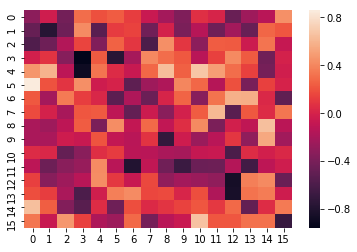

In [103]:
heatmap(translate[6].reshape(16, 16))

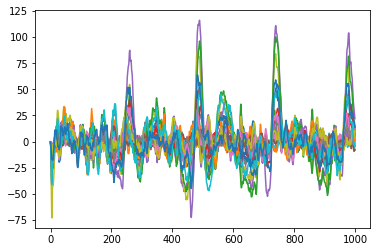

In [145]:
plt.plot(data_x[2])

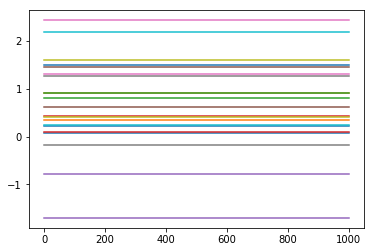

In [146]:
plt.plot(model.predict(data_x[2].reshape(1,1000,21)).reshape(1000,21))

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1000, 21)          0         
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 1000, 21)          0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1000, 256)         5632      
_________________________________________________________________
reshape_3 (Reshape)          (None, 1000, 16, 16, 1)   0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 1000, 16, 16, 1)   4         
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 1000, 16, 16, 1)   28        
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 500, 16, 16, 1)    0         
__________

## Try 2d without any fancy layering magic

In [21]:
from keras_models.cnn_models import conv2d_gridsearch_pre_layers
from keras.layers import Input, Reshape, Dense, TimeDistributed, Dropout, Conv2D, BatchNormalization, MaxPool2D, Flatten, GaussianNoise, UpSampling2D, Lambda
from keras import Model
from keras.optimizers import Adam
# pre_layer_h = 16
x = Input((1000, 21)) #time, ecg channel, 
# y = GaussianNoise(5)(x)
# y = TimeDistributed(Dense(pre_layer_h**2, activation="linear"))(x)
y = Reshape((1000, 21, 1))(x) #add back in channel dim

In [15]:
# y = Conv2D(1, (4,4), padding="same")(y)
# y = MaxPool2D((2,1), padding="same")(y)
# y = Conv2D(1, (4,4), padding="same")(y)
# y = UpSampling2D((2,1),)(y)
# y = Reshape((1000, 21))(y)

In [22]:
for i in range(4):
    y = BatchNormalization()(y)
    y = Conv2D(2**i, (4,4), activation="relu", padding="same")(y)
    y = MaxPool2D((2, 1), padding="same")(y)
    
for i in range(2):
    y = BatchNormalization()(y)
    y = Conv2D(2**(i+4), (4,4), activation="relu", padding="same")(y)
    y = MaxPool2D((2, 2), padding="same")(y)

In [64]:
# encoded = Dense(8**3)(Flatten()(y))
# y = Reshape((8, 8, 8))(encoded)

In [23]:
for i in range(2):
    y = BatchNormalization()(y)
    y = Conv2D(2**(5 - i), (4,4), activation="relu", padding="same")(y)
    y = UpSampling2D((2, 2))(y)
    
for i in range(4):
    y = BatchNormalization()(y)
    y = Conv2D(2**(3-i), (4,4), activation="relu", padding="same")(y)
    y = UpSampling2D((2, 1))(y)

In [24]:
y = Reshape((1024, 24))(y)
y = TimeDistributed(Dense(21, activation="linear"))(y)

In [25]:
y = Lambda(lambda x: x[:, 12:1012, 0:21], output_shape=(1000,21))(y)

In [26]:
model = Model(inputs=x, outputs=y)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1000, 21)          0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 1000, 21, 1)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1000, 21, 1)       4         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 1000, 21, 1)       17        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 500, 21, 1)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 500, 21, 1)        4         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 500, 21, 2)        34        
__________

In [8]:
from keras import optimizers

In [31]:
model.compile(optimizer=optimizers.Adam(lr=0.0005), loss="mean_squared_error",)

In [34]:
import keras.callbacks as cb
history = model.fit(data_x, data_x, batch_size=64, epochs=300, callbacks=[cb.ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, verbose=True, cooldown=5)])

Epoch 1/300
5000/5000 [==============================] - 3s 613us/step - loss: 4406.5943
Epoch 2/300
5000/5000 [==============================] - 3s 626us/step - loss: 4360.5599
Epoch 3/300
5000/5000 [==============================] - 3s 606us/step - loss: 4418.8165
Epoch 4/300
5000/5000 [==============================] - 3s 605us/step - loss: 4400.6291
Epoch 5/300
5000/5000 [==============================] - 3s 609us/step - loss: 4400.1321
Epoch 6/300
5000/5000 [==============================] - 3s 624us/step - loss: 4495.1779
Epoch 7/300
5000/5000 [==============================] - 3s 607us/step - loss: 4340.2770
Epoch 8/300
5000/5000 [==============================] - 3s 604us/step - loss: 4330.4303
Epoch 9/300
5000/5000 [==============================] - 3s 612us/step - loss: 4278.0607
Epoch 10/300
5000/5000 [==============================] - 3s 622us/step - loss: 4343.4438
Epoch 11/300
5000/5000 [==============================] - 3s 607us/step - loss: 4323.1741
Epoch 12/300
5000/5

5000/5000 [==============================] - 3s 627us/step - loss: 4131.6232

Epoch 00168: ReduceLROnPlateau reducing learning rate to 3.2768001501223487e-15.
Epoch 169/300
5000/5000 [==============================] - 3s 609us/step - loss: 4136.8206
Epoch 170/300
5000/5000 [==============================] - 3s 620us/step - loss: 4291.3625
Epoch 171/300
5000/5000 [==============================] - 3s 619us/step - loss: 4112.4546
Epoch 172/300
5000/5000 [==============================] - 3s 616us/step - loss: 4133.7831
Epoch 173/300
5000/5000 [==============================] - 3s 623us/step - loss: 4126.0154
Epoch 174/300
5000/5000 [==============================] - 3s 607us/step - loss: 4173.2845
Epoch 175/300
5000/5000 [==============================] - 3s 629us/step - loss: 4175.9573
Epoch 176/300
5000/5000 [==============================] - 3s 608us/step - loss: 4131.6483
Epoch 177/300
5000/5000 [==============================] - 3s 629us/step - loss: 4303.2908

Epoch 00177: ReduceLR

5000/5000 [==============================] - 3s 622us/step - loss: 4149.2380
Epoch 251/300
5000/5000 [==============================] - 3s 621us/step - loss: 4193.1434
Epoch 252/300
5000/5000 [==============================] - 3s 619us/step - loss: 4124.9931
Epoch 253/300
5000/5000 [==============================] - 3s 613us/step - loss: 4138.4051
Epoch 254/300
5000/5000 [==============================] - 3s 623us/step - loss: 4133.9203
Epoch 255/300
5000/5000 [==============================] - 3s 610us/step - loss: 4126.7462
Epoch 256/300
5000/5000 [==============================] - 3s 628us/step - loss: 4149.7935
Epoch 257/300
5000/5000 [==============================] - 3s 608us/step - loss: 4147.8869
Epoch 258/300
5000/5000 [==============================] - 3s 608us/step - loss: 4228.0933

Epoch 00258: ReduceLROnPlateau reducing learning rate to 3.355443614537152e-22.
Epoch 259/300
5000/5000 [==============================] - 3s 627us/step - loss: 4247.2491
Epoch 260/300
5000/5000

In [95]:
model.compile(optimizer=optimizers.Adam(lr=0.001), loss="mean_squared_error")
model.fit(data_x[0:1000], data_x[0:1000], batch_size=64, epochs=10)

Epoch 1/10
1000/1000 [==============================] - 30s 30ms/step - loss: 10252.0820
Epoch 2/10
1000/1000 [==============================] - 18s 18ms/step - loss: 9804.8523
Epoch 3/10
1000/1000 [==============================] - 18s 18ms/step - loss: 9860.0697
Epoch 4/10
1000/1000 [==============================] - 18s 18ms/step - loss: 9945.9150
Epoch 5/10
1000/1000 [==============================] - 18s 18ms/step - loss: 9819.6136
Epoch 6/10
1000/1000 [==============================] - 18s 18ms/step - loss: 9945.9986
Epoch 7/10
1000/1000 [==============================] - 18s 18ms/step - loss: 9698.5559
Epoch 8/10
1000/1000 [==============================] - 18s 18ms/step - loss: 9568.8256
Epoch 9/10
1000/1000 [==============================] - 18s 18ms/step - loss: 9779.8956
Epoch 10/10
1000/1000 [==============================] - 18s 18ms/step - loss: 9935.3519


In [96]:
from keras import backend as K
sess = K.get_session()
with sess.as_default():
    translate = model.layers[2].layer.weights[0].eval()

In [97]:
mapping = translate.reshape((21, 16, 16)).argmax(axis=0)

In [98]:
mapping

array([[16, 16,  9,  1, 18,  9,  9, 16, 16,  9,  6,  8,  8,  1,  1, 16],
       [16, 20,  1,  9,  1,  9,  2,  1,  9,  9,  8,  8,  1,  1, 14, 16],
       [16,  6,  6, 17, 15,  6,  9,  9,  6,  9,  3,  6,  1, 16, 16,  1],
       [ 6,  6,  3,  4,  6,  8,  9,  6, 18,  9,  3,  4, 15,  3,  1,  1],
       [ 6, 15,  1,  4,  4, 13,  6,  9, 20,  6,  9, 16,  6,  8,  7, 16],
       [16, 17,  8,  8, 18,  9, 16,  8,  8,  4, 16, 16,  4,  8, 19,  4],
       [10,  9,  8, 12,  4,  4,  4,  8,  4,  4, 16,  4,  4, 10,  0, 16],
       [ 9,  1, 15,  8,  8,  4, 14, 19,  8, 13,  6,  4,  4, 16, 16,  6],
       [ 6,  4,  3,  6,  3,  1,  5,  9, 19,  0, 20, 20, 20,  4, 20, 15],
       [16,  3,  3,  6,  6,  3,  6,  0,  3,  0,  9,  1, 16, 20,  6,  4],
       [ 2, 20,  8,  8,  6, 12, 15,  3,  3,  9, 15,  2,  3,  1,  9,  9],
       [ 4, 17,  8, 20,  6,  2, 17, 15,  9,  9, 20,  2,  7,  5, 16,  8],
       [16, 17,  4,  2,  9,  8,  6,  9,  3, 10, 16, 16,  8,  7,  4,  8],
       [ 4,  4, 11, 17,  2,  6, 12,  9,  6,  1,  2,

In [99]:
from seaborn import heatmap

In [102]:
util_funcs.get_common_channel_names()[6]

'EEG CZ-REF'

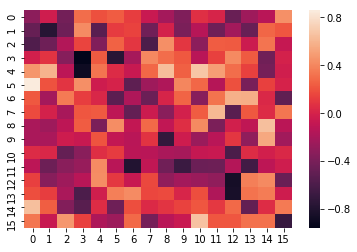

In [103]:
heatmap(translate[6].reshape(16, 16))

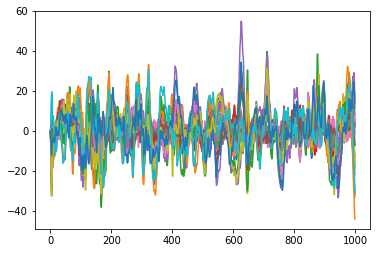

In [19]:
plt.plot(data_x[0])

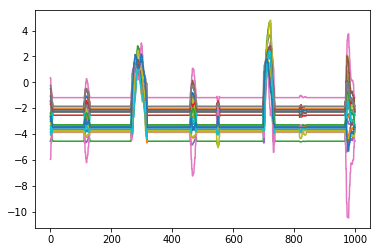

In [35]:
plt.plot(model.predict(data_x[0].reshape(1,1000,21)).reshape(1000,21))

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1000, 21)          0         
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 1000, 21)          0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1000, 256)         5632      
_________________________________________________________________
reshape_3 (Reshape)          (None, 1000, 16, 16, 1)   0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 1000, 16, 16, 1)   4         
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 1000, 16, 16, 1)   28        
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 500, 16, 16, 1)    0         
__________